In [35]:
import torch
import torch.nn as nn
from torch_geometric.nn import VGAE, NNConv
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
import os
from pathlib import Path

In [36]:
def load_graphs(graph_dir):
    # Vérification du dossier
    graph_dir = Path(graph_dir)
    if not graph_dir.exists():
        raise FileNotFoundError(
            f"Le dossier '{graph_dir}' n'existe pas."
        )
    if not graph_dir.is_dir():
        raise NotADirectoryError(
            f"'{graph_dir}' n'est pas un dossier valide."
        )
    graphs = []
    # Charger tous les fichiers .pt
    for file_path in sorted(graph_dir.glob("*.pt")):
        try:
            g = torch.load(file_path)
            graphs.append(g)
            print(f"Graphe chargé : {file_path}")
        except Exception as e:
            print(f"Erreur lors du chargement de {file_path} : {e}")
    return graphs

# Charger les graphes
train_graphs_dir = "graphs/train"
test_graphs_dir = "graphs/test"

train_graphs = load_graphs(train_graphs_dir)
test_graphs = load_graphs(test_graphs_dir)

Graphe chargé : graphs/train/graph_batch_1.pt
Graphe chargé : graphs/train/graph_batch_10.pt
Graphe chargé : graphs/train/graph_batch_11.pt
Graphe chargé : graphs/train/graph_batch_12.pt
Graphe chargé : graphs/train/graph_batch_2.pt
Graphe chargé : graphs/train/graph_batch_3.pt
Graphe chargé : graphs/train/graph_batch_4.pt
Graphe chargé : graphs/train/graph_batch_5.pt
Graphe chargé : graphs/train/graph_batch_6.pt
Graphe chargé : graphs/train/graph_batch_7.pt
Graphe chargé : graphs/train/graph_batch_8.pt
Graphe chargé : graphs/train/graph_batch_9.pt
Graphe chargé : graphs/test/graph_batch_1.pt
Graphe chargé : graphs/test/graph_batch_2.pt
Graphe chargé : graphs/test/graph_batch_3.pt
Graphe chargé : graphs/test/graph_batch_4.pt
Graphe chargé : graphs/test/graph_batch_5.pt
Graphe chargé : graphs/test/graph_batch_6.pt
Graphe chargé : graphs/test/graph_batch_7.pt


/tmp/ipykernel_88022/3133579107.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  g = torch.load(file_path)


## Split temporel (train / val)

In [37]:
num_graphs = len(train_graphs)

train_ratio = 0.8

train_end = int(train_ratio * num_graphs)

val_graphs   = train_graphs[train_end:]
train_graphs = train_graphs[:train_end]


# Créer un DataLoader pour l'entraînement
# batch_size = nombre de graphes dans chaque batch
batch_size = 1

train_loader = DataLoader(
    train_graphs,
    batch_size=batch_size,
    shuffle=False
)

val_loader = DataLoader(
    val_graphs,
    batch_size=batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_graphs,
    batch_size=batch_size,
    shuffle=False
)

## Normalisation des features

In [38]:
# calcul mean/std sur tous les noeuds du graphe
xs = torch.cat([g.x for g in train_graphs], dim=0)
mean = xs.mean(dim=0)
std = xs.std(dim=0) + 1e-6

def normalize_graph(g):
    g.x = (g.x - mean) / std
    return g

train_graphs = [normalize_graph(g) for g in train_graphs]
val_graphs   = [normalize_graph(g) for g in val_graphs]
test_graphs   = [normalize_graph(g) for g in test_graphs]

## Définir l’encodeur (avec NNConv)

In [5]:
class NNConvEncoder(nn.Module):
    def __init__(self, in_channels, out_channels, edge_dim):
        super(NNConvEncoder, self).__init__()

        self.out_channels = out_channels
        # MLP pour transformer edge_attr en matrice de poids pour NNConv
        self.edge_mlp = nn.Sequential(
            nn.Linear(edge_dim, in_channels * 2 * out_channels),
            nn.ReLU()
        )

        # première couche NNConv
        self.conv1 = NNConv(
            in_channels=in_channels,
            out_channels=2 * out_channels,
            nn=self.edge_mlp,
            aggr='mean'
        )

        # couches mu et logvar
        self.conv_mu = NNConv(
            in_channels=2 * out_channels,
            out_channels=out_channels,
            nn=nn.Sequential(
                nn.Linear(edge_dim, 2 * out_channels * out_channels),
                nn.ReLU()
            ),
            aggr='mean'
        )

        self.conv_logvar = NNConv(
            in_channels=2 * out_channels,
            out_channels=out_channels,
            nn=nn.Sequential(
                nn.Linear(edge_dim, 2 * out_channels * out_channels),
                nn.ReLU()
            ),
            aggr='mean'
        )

    def forward(self, x, edge_index, edge_attr):
        # Couche 1
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        # Mu et LogVar pour VGAE
        mu = self.conv_mu(x, edge_index, edge_attr)
        logvar = self.conv_logvar(x, edge_index, edge_attr)
        return mu, logvar


## Créer le modèle VGAE

In [6]:
# Dimensions extraites depuis UN graphe (tous ont la même structure)
in_channels = train_graphs[0].x.shape[1]        # features par nœud
out_channels = 32                               # dimension latente
edge_dim = train_graphs[0].edge_attr.shape[1]   # features par arête

encoder = NNConvEncoder(in_channels, out_channels, edge_dim)
model = VGAE(encoder)


## Définir l’optimiseur

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


## Détecter le device (GPU si dispo)

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
device = torch.device("cpu")
# Déplacer le modèle
model = model.to(device)

Using device: cpu


## Early Stopping

In [9]:
patience = 10  # nombre d'époques sans amélioration
best_loss = float('inf')
counter = 0

## Entraînement du modèle

In [10]:
num_epochs = 200

for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss = 0.0
    
    # ===== ENTRAÎNEMENT SUR LE PASSÉ =====
    for t, data in enumerate(train_loader):
        assert data.edge_index.dtype == torch.long
        assert data.edge_index.min() >= 0
        assert data.edge_index.max() < data.num_nodes
        # Chaque data = 1 graphe temporel
        data = data.to(device)

        # Sécurité NNConv
        assert data.edge_attr is not None
        assert data.edge_attr.dim() == 2
        assert data.edge_attr.size(0) == data.edge_index.size(1)
        data.edge_attr = data.edge_attr.float()

        optimizer.zero_grad()
        # Encodage VGAE (NNConv utilise edge_attr)
        z = model.encode(
            data.x,
            data.edge_index,
            data.edge_attr
        )
        # Loss VGAE = reconstruction + KL
        recon_loss = model.recon_loss(z, data.edge_index) / data.num_nodes  # normalisation
        kl_loss = model.kl_loss() / data.num_nodes  # normalisation
        loss = recon_loss + kl_loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # ===== VALIDATION SUR LE FUTUR (SANS BACKPROP) =====
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            data.edge_attr = data.edge_attr.float()

            z = model.encode(
                data.x,
                data.edge_index,
                data.edge_attr
            )

            recon_loss = model.recon_loss(z, data.edge_index) / data.num_nodes  # normalisation
            kl_loss = model.kl_loss() / data.num_nodes

            val_loss += (recon_loss + kl_loss).item()

    print(
        f"Epoch {epoch:03d} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f}"
    )

    # ===== EARLY STOPPING TEMPOREL =====
    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best_vgae_nnconv.pt")
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break


Epoch 001 | Train Loss: 158995.2100 | Val Loss: 63677.2090
Epoch 002 | Train Loss: 132570.2715 | Val Loss: 51517.5967
Epoch 003 | Train Loss: 107874.3208 | Val Loss: 40535.1768
Epoch 004 | Train Loss: 85972.2202 | Val Loss: 31355.7217
Epoch 005 | Train Loss: 67815.3965 | Val Loss: 24143.5425
Epoch 006 | Train Loss: 53497.3809 | Val Loss: 18700.4707
Epoch 007 | Train Loss: 42519.3059 | Val Loss: 14642.4219
Epoch 008 | Train Loss: 34129.4596 | Val Loss: 11613.7466
Epoch 009 | Train Loss: 27700.3402 | Val Loss: 9308.6384
Epoch 010 | Train Loss: 22677.0789 | Val Loss: 7517.7942
Epoch 011 | Train Loss: 18692.8761 | Val Loss: 6123.5822
Epoch 012 | Train Loss: 15518.5416 | Val Loss: 5021.5948
Epoch 013 | Train Loss: 12957.3609 | Val Loss: 4140.5568
Epoch 014 | Train Loss: 10874.2217 | Val Loss: 3430.0919
Epoch 015 | Train Loss: 9172.0942 | Val Loss: 2858.9191
Epoch 016 | Train Loss: 7781.8928 | Val Loss: 2396.7590
Epoch 017 | Train Loss: 6640.7349 | Val Loss: 2020.3432
Epoch 018 | Train Loss:

## Charger le modèle

In [39]:
# Charger le meilleur modèle
model.load_state_dict(torch.load("best_vgae_nnconv.pt"))


/tmp/ipykernel_88022/2650110910.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_vgae_nnconv.pt"))


<All keys matched successfully>

## Score de reconstruction par ARÊTE

In [40]:
def edge_recon_error(z, edge_index):
    src, dst = edge_index
    logits = (z[src] * z[dst]).sum(dim=1)
    probs = torch.sigmoid(logits)
    error = -torch.log(probs + 1e-9)
    return error  # [num_edges]


## Agrégation vers les NŒUDS

In [41]:
def node_anomaly_score(z, edge_index, num_nodes):
    edge_error = edge_recon_error(z, edge_index)

    src, dst = edge_index
    node_score = torch.zeros(num_nodes, device=z.device)
    node_score.scatter_add_(0, src, edge_error)
    node_score.scatter_add_(0, dst, edge_error)

    degree = torch.zeros(num_nodes, device=z.device)
    degree.scatter_add_(0, src, torch.ones_like(edge_error))
    degree.scatter_add_(0, dst, torch.ones_like(edge_error))

    return node_score / (degree + 1e-6)


## Collecte sur les données de valisation

In [42]:
val_scores = []
val_labels = []

model.eval()
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)

        z = model.encode(
            data.x,
            data.edge_index,
            data.edge_attr.float()
        )

        scores = node_anomaly_score(
            z,
            data.edge_index,
            data.num_nodes
        )

        print("data.y:", data.y)
        print("scores:", scores.shape)

        val_scores.extend(scores.cpu().numpy())
        val_labels.extend(data.y.cpu().numpy())


data.y: tensor([0, 0, 0,  ..., 0, 0, 0])
scores: torch.Size([30058])
data.y: tensor([0, 0, 0,  ..., 0, 0, 0])
scores: torch.Size([85848])
data.y: tensor([0, 0, 0,  ..., 0, 0, 0])
scores: torch.Size([88759])
data.y: tensor([0, 0, 0,  ..., 0, 0, 0])
scores: torch.Size([69533])
data.y: tensor([0, 0, 0,  ..., 0, 0, 0])
scores: torch.Size([69348])
data.y: tensor([0, 0, 0,  ..., 0, 0, 0])
scores: torch.Size([72635])
data.y: tensor([0, 0, 0,  ..., 0, 0, 0])
scores: torch.Size([139538])


## Choisir un seuil

In [49]:
import numpy as np

threshold = np.percentile(val_scores, 99)


## TEST

In [50]:
test_scores = []
test_labels = []
test_preds  = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)

        z = model.encode(
            data.x,
            data.edge_index,
            data.edge_attr.float()
        )

        scores = node_anomaly_score(
            z,
            data.edge_index,
            data.num_nodes
        )

        preds = (scores > threshold).long()

        test_scores.extend(scores.cpu().numpy())
        test_labels.extend(data.y.cpu().numpy())
        test_preds.extend(preds.cpu().numpy())


## Matrice de confusion

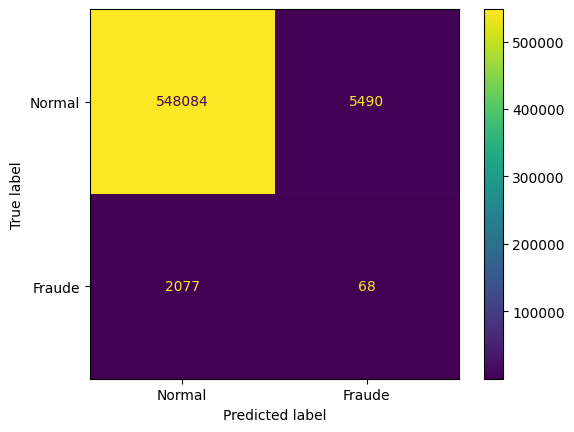

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_labels, test_preds)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Normal", "Fraude"]
)
disp.plot()
